In [1]:
from functools import partial
from math import sqrt
from pathlib import Path
import geopandas as gpd
from itertools import product
import time
import timeit
import csv

In [2]:
input_dir = Path('vector_1000')
output_dir = Path.cwd()

# Get a list of all GPKG files in the folder
v_files = list(sorted(input_dir.glob('*.gpkg')))

In [3]:
# Specify the number of files to open
num_files_to_open = 10
bench_runs=30  #Benchmark runs, should probably do 30 

In [4]:
# Loop through each GPKG file and join
for i, file in enumerate(v_files[:num_files_to_open]):
    col_name = file.stem.split('_')[1]  # Extracting the column name from the file name
    df = gpd.read_file(file)
    df.columns = [col_name, *df.columns[1:]] #Setting the column to the file
    if i == 0:
        combined_df = df.copy()
    else:
        combined_df = gpd.overlay(combined_df, df)

Benchmarking for joining

In [5]:
joining_time = []
def run_loop(num_files_to_open, v_files):
    
    join_time= []
    start_time = time.time()
    for i, file in enumerate(v_files[:num_files_to_open]):
        col_name = file.stem.split('_')[1]  # Extracting the column name from the file name
        df = gpd.read_file(file)
        df.columns = [col_name, *df.columns[1:]] #Setting the column to the file

        #Joining benchmark
        join_Stime=time.time()
        if i == 0:
            combined_df = df.copy()
        else:
            combined_df = gpd.overlay(combined_df, df) 
        join_Etime=time.time()
        join_Ftime = join_Etime - join_Stime
        join_time.append(join_Ftime)
        
    end_time = time.time()
    
    # Calculate and print the time taken for each run
    time_taken = end_time - start_time
    joining_time.append(sum(join_time))
    print(f'Run: Joining time- {sum(join_time)} , Total Time taken - {time_taken} seconds')

In [6]:
timeit.timeit(lambda: run_loop(num_files_to_open, v_files), number=bench_runs) #Benchmark run for joining

Run: Joining time- 0.5202240943908691 , Total Time taken - 0.6202132701873779 seconds
Run: Joining time- 0.5236790180206299 , Total Time taken - 0.6122283935546875 seconds
Run: Joining time- 0.46819043159484863 , Total Time taken - 0.5765480995178223 seconds
Run: Joining time- 0.49802589416503906 , Total Time taken - 0.6105389595031738 seconds
Run: Joining time- 0.46504855155944824 , Total Time taken - 0.5619938373565674 seconds
Run: Joining time- 0.42818784713745117 , Total Time taken - 0.5103425979614258 seconds
Run: Joining time- 0.5074458122253418 , Total Time taken - 0.6106369495391846 seconds
Run: Joining time- 0.4679577350616455 , Total Time taken - 0.5776517391204834 seconds
Run: Joining time- 0.45027923583984375 , Total Time taken - 0.5533428192138672 seconds
Run: Joining time- 0.5080463886260986 , Total Time taken - 0.6014740467071533 seconds
Run: Joining time- 0.5153756141662598 , Total Time taken - 0.6122305393218994 seconds
Run: Joining time- 0.5050654411315918 , Total Tim

17.08970340003725

Defining classes

In [7]:
def is_prime(n):
    count = 0
    if n > 1:
        for i in range(1, n + 1):
            if n % i == 0:
                count += 1
    return count == 2

def is_polygonal(s, x):
    assert s > 2 and s % 1 == 0 and x % 1 == 0
    n = (sqrt(8 * (s - 2) * x + (s - 4) ** 2) + (s - 4)) / (2 * (s - 2))
    return n % 1 == 0

def is_fibonacci(n):
    a, b = 0,1
    while a < n:
        a, b = b, a + b
    return a == n

def is_perfect(n):
    sum = 1
    i = 2
    while i * i <= n:
        if n % i == 0:
            sum = sum + i + n/i
        i += 1
    return sum == n and n != 1

In [8]:
combined_df['sum'] = combined_df.select_dtypes(include='number').sum(axis=1)
classes = [
    ('is_prime', is_prime),
    ('is_triangular', partial(is_polygonal, 3)),
    ('is_rectangular', partial(is_polygonal, 4)),
    ('is_pentagonal', partial(is_polygonal, 5)),
    ('is_hexagonal', partial(is_polygonal, 6)),
    ('is_fibonacci', is_fibonacci),
    ('is_perfect', is_perfect),
]
for i, func in enumerate(classes):
    combined_df[func[0]] = combined_df['sum'].apply(func[1])

In [9]:
numerics = list(combined_df.select_dtypes(include='number'))
combined_df = combined_df.drop(columns=numerics)

In [10]:
combinations = list(product([True, False], repeat=7))
class_mapping = {tuple(row): f'Class_{i+1:03}' for i, row in enumerate(combinations)}

Benchmarking Classification

In [11]:
classify_time=[]
def classify_loop():
    
    start_time = time.time()

    bench_class = combined_df[['is_prime','is_triangular','is_rectangular','is_pentagonal','is_hexagonal','is_fibonacci','is_perfect']].apply(lambda row: class_mapping[tuple(row.astype(int))], axis=1) #This should remain the same, as cell count remains static   

    end_time = time.time()
    
    # Calculate and print the time taken for each run
    time_taken = end_time - start_time
    classify_time.append(time_taken)
    print(f'Run: Time taken - {time_taken} seconds')

In [12]:
timeit.timeit(lambda: classify_loop(), number=bench_runs) #Benchmark run for classifying

Run: Time taken - 0.03500938415527344 seconds
Run: Time taken - 0.02735590934753418 seconds
Run: Time taken - 0.031952857971191406 seconds
Run: Time taken - 0.031029462814331055 seconds
Run: Time taken - 0.0318303108215332 seconds
Run: Time taken - 0.0414884090423584 seconds
Run: Time taken - 0.031230449676513672 seconds
Run: Time taken - 0.04008340835571289 seconds
Run: Time taken - 0.03985452651977539 seconds
Run: Time taken - 0.04344630241394043 seconds
Run: Time taken - 0.042198896408081055 seconds
Run: Time taken - 0.027465105056762695 seconds
Run: Time taken - 0.03092789649963379 seconds
Run: Time taken - 0.020764589309692383 seconds
Run: Time taken - 0.030611753463745117 seconds
Run: Time taken - 0.03111410140991211 seconds
Run: Time taken - 0.0414891242980957 seconds
Run: Time taken - 0.041376590728759766 seconds
Run: Time taken - 0.040853023529052734 seconds
Run: Time taken - 0.030421972274780273 seconds
Run: Time taken - 0.04037356376647949 seconds
Run: Time taken - 0.0333006

1.0830287000862882

Writing benchmark results

In [13]:
with open(f'Vector_benchmark_{num_files_to_open}_layers.csv', 'w', newline='') as csvfile: #Writing benchmark results
    writer = csv.writer(csvfile)
    writer.writerow(['Run', 'Joining(s)','Classify(s)'])
    for i, (join_taken, classify_taken) in enumerate(zip(joining_time, classify_time)):
        writer.writerow([i+1, join_taken, classify_taken])

Applying classification

In [14]:
combined_df['class'] = combined_df[['is_prime','is_triangular','is_rectangular','is_pentagonal','is_hexagonal','is_fibonacci','is_perfect']].apply(lambda row: class_mapping[tuple(row.astype(int))], axis=1)
combined_df=combined_df[['class','geometry']]

In [15]:
output_dir.mkdir(parents=True, exist_ok=True)
output = (output_dir / f'Vector_{num_files_to_open}_layers.gpkg')
# output.touch(exist_ok=True)
combined_df.to_file(output, layer='benchmarking', driver='GPKG', mode='w')

<Axes: >

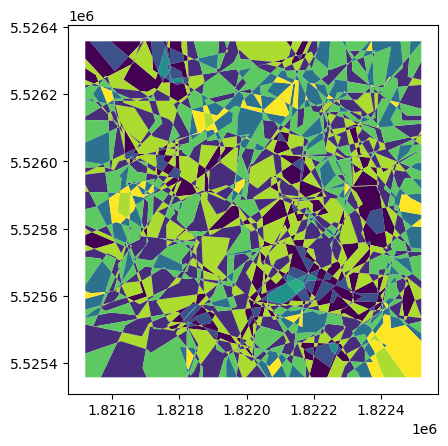

In [16]:
combined_df.plot('class', cmap='viridis')